# fast estimation of particle properties
Tim Tyree<br>
9.29.2021<br>
`conda activate pyenv_ub`

__TODO(later):__ bug mike to make certain that for the 99.95% accurate decoder, that the i^th neuron for the Match trials is the same as the i^th neuron for the Mismatch trials for all i neuron-units considered.

__TODO__: use more smoothing than just tavg1=2 or 4

__GOAL__: efficiently generate an inline rendering of dRdt versus 1/R and MSD versus tau using dashly.  try the solution suggested on my stackoverflow post

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (optional) postprocess a token trajectory file
- Nota Bene: batch computation is already automated and optimized in 'fast postprocessing a list of trajectory folders.ipynb'

In [3]:
# input_fn=search_for_file()

# # #token FK at DT=0.4
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"

# # #tokenLR at DT=0.5
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.31_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv"

#test routine on one file
testing=False
if testing:
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df),5);print(f"DT={DT}")
    # ds=5 #cm
    # DS=ds/width
    tavg1=4 #moving average window, in ms
    width=200
    height=width
    use_drop_shorter_than=True
    drop_shorter_than=50 #ms
    tmin=100.#ms
    pid_col='particle'
    t_col='t'
    printing=False
    navg1=int(tavg1/DT)
    save_dir=return_moving_average_of_pbc_trajectories_and_save(
            input_fn, tavg1, pid_col, t_col, DT, width, height,
            use_drop_shorter_than, drop_shorter_than, tmin, printing)
    print(save_dir)

    df=load_smoothed_trajectories(save_dir,pid_col,t_col)
    df.head()

In [4]:
#run the routine on a whole folder
# print((DT, input_fn))
# save_dir_lst=routine_postprocess_trajectory_folder(input_fn,DT,tavg1=4, npartitions=None,
#                                         width=200,
#                                         height=200,
#                                         use_drop_shorter_than=True,
#                                         drop_shorter_than=50, #ms
#                                         tmin=100., #ms
#                                         pid_col='particle',
#                                         t_col='t',
#                                         printing=False)

In [5]:
# #TODO(later): compute squared displacements
# grouped=df.groupby(pid_col)
# #HINT: squared displacements of particles is result
#  throws AttributeError: DataFrameGroupBy object has no attribute first 
# result = (grouped[['x','y']]-grouped[['x','y']].first())**2

In [6]:
#TODO(later): implement a one_step method on an element in a finite element simulation
# HINT: cudf.Grouper?
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#grouping-with-a-grouper-specification
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

In [7]:
#DONE: figure out if there's an elegant was to use the cudf api  to do this
#for each group of event_id_int's :
#compare every particle to every other particle in a simple way
#compare every particle to every other particle to determine if the self,other pair intersects nontrivially

#DONE: determine condition for whether each pair is intersecting for at least two times 
# two particles exist for at least two times if both
#if other has a tmin > tmin of self
#AND if other has a tmax < tmax of self, 

# #DONE: construct the graph of all edges... this wasn't useful...
# G = cugraph.Graph()
# G.from_cudf_edgelist(df_pairs, source='src', destination='dst', edge_attr='dst')
# # # Let's now get the PageRank score of each vertex by calling cugraph.pagerank
# # df_page = cugraph.pagerank(G)
# # df_page.head()

In [8]:
#DONE: compute which edges are intersecting
#DONE: compute tmin and tmax for each intersecting edge
#DONE: compute duration for each intersecting edge
#DONE: sort edges by duration
#DONE: visualize the histogram of durations of intersecting edges
#DONE: consider a minimum_duration_threshold that is at least tavg2 if not specified

## scratchwerk

In [9]:
#DONT: figure out terrible numba debugging for a negligible speed boost
# @cuda.jit()#device=True)
# def distance_L2_pbc_cuda(point_1, point_2, dist_out, shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     blockspergrid=1
#     threadsperblock=1
#     point_1=self_values[0]
#     point_2=other_values[0]
#     dist_out=0.#overwritten
#     shape=(width,height)
#     distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
#     '''
#     dq2 = 0.
#     for q1, q2, wid in zip(point_1, point_2, shape):
#         dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#     dist_out= dq2**0.5

# blockspergrid=1
# threadsperblock=1
# point_1=self_values[0]
# point_2=other_values[0]
# dist_out=np.array([0.])#*self_values
# shape=(width,height)
# # distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)
# distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# dist_out, point_1, point_2

# from numba import vectorize
# # shape=(width,height)
# # @vectorize(['float32[:](float32, float32, float32)'], target='cuda')
# shape=cp.array((width,height))
# @vectorize(['(float32[:,:], float32[:,:], float32[:,:], float32[:])'], target='cuda')
# def distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape):
#     for point_1, point_2, dist_out in zip(self_values, other_values, dist_out_values):
#         distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)

# # blockspergrid=1
# # threadsperblock=1
# dist_out_values=0.*self_values
# shape=cp.array((width,height))
# distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape)
# # distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# # dist_out

# define module

In [10]:
def extract_xy_values_of_pair(df,pair,t_col='t'):
    '''
    df is a cudf.DataFrame instance of xy trajectories from no more than 1 trial 
    pair is a row from a pandas.core.series.Series instance with columns,['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self', 'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int']
    
    Example Usage:
    pair=pd.Series(df_pairs.head(1).to_pandas())
    event_id_int=int(pair[trial_col])#.values.get())
    dff=df[df[trial_col]==event_id_int]
    self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
    '''
    dff=df
    #DONE: optimize data retrieval from pair by using only one gpu-to-cpu memory transfer
    pid_self =int(pair['pid_self'])#.values.get())
    pid_other=int(pair['pid_other'])#.values.get())
    tmin     =float(pair['tmin'])#.values.get())
    tmax     =float(pair['tmax'])#.values.get())
    #failed to broadcase in cudf
    #     if event_id_int is not None:
    #         dff=df[df[trial_col]==event_id_int]
    #     else:
    #         dff=df
    df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
    df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
    self_values=df_self.loc[(df_self[t_col]>=tmin)&(df_self[t_col]<=tmax),['x','y']].values
    other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
    return self_values,other_values

In [11]:
# pair=df_pairs.head(1)
# event_id_int=int(pair[trial_col].values.get())
# dff=df[df[trial_col]==event_id_int]
# self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
# print((self_values.shape,other_values.shape))
# assert ( self_values.shape==other_values.shape ) 

In [12]:
def distance_L2_pbc_cu(self_values,other_values,shape):
    '''distance_L2_pbc_cu is a jit compiled function that 
    returns for the euclidean (L2) distance between 
    point_1 and point_2, which are in an N-cube of shape shape 
    with periodic boundary conditions
    
    Example Usage:
    shape=(width,height)
    dist_values=distance_L2_pbc_cu(self_values,other_values,shape)
    '''
    sqdiff_values = (self_values-other_values)**2
    #compute the other pbc options for sqdiff_values for each column
    for n,w in enumerate(shape):
        self_w_values  = self_values[:,n]
        other_w_values = other_values[:,n]
        sqdiff_w_values= sqdiff_values[:,n]
        sqdiff_wp_values=(self_w_values-other_w_values-w)**2
        sqdiff_wm_values=(self_w_values-other_w_values+w)**2
        boop=sqdiff_wp_values<sqdiff_w_values
        boom=sqdiff_wm_values<sqdiff_w_values
        sqdiff_values[boop,n]=sqdiff_wp_values[boop]
        sqdiff_values[boom,n]=sqdiff_wm_values[boom]

    dist_values=cp.sqrt(cp.sum(sqdiff_values,axis=1))
    return dist_values

# TODO: compute dRdt versus 1/R for unconstrained random samples from smoothed and validated trajectories

__Note:__ cugraph is a great tool for complex problems that happen in terms of graphs that benefit from visualization.  My graph problem is low-level, and therefore it does not appear beneficial for me to use cugraph here.

In [13]:
#define parameters
trial_col='event_id_int'
pid_col='particle' 
t_col='t' 
width=200
height=200
tmin=100.
printing=True

#new parameters specific to radial time series filtration
tavg2=0.
minimum_duration_threshold=tavg2
minimum_duration_threshold=25 #ms

In [14]:
#recall a couple postprocessed single trials
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.11_traj_sr_600_mem_0_smoothed.csv"
# input_fn2=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.12_traj_sr_600_mem_0_smoothed.csv"
# input_fn_lst=[input_fn,input_fn2]
# df=dask_cudf.read_csv(input_fn_lst).compute()
df=cudf.read_csv(input_fn)
df=df.sort_values([trial_col,pid_col, t_col], ascending=True).copy()
DT=get_DT_cu(df,t_col,pid_col)
navg2=int(tavg2/DT)
if printing:
    print(f"DT={DT} ms")

DT=0.5 ms


In [15]:
#compute the intermediate dataframe of particle start/end times
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
# dff.head()

In [16]:
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)
df_intersecting_pairs_all.head()

using 1 cores to identify pairs of particles that coexist over 1 independent trials...


,pid_self,pid_other,tmin_self,tmin_other,tmax_self,tmax_other,tmin,tmax,duration,event_id_int
0,1509,1519,3170.0,3239.5,3341.5,3341.5,3239.5,3341.5,102.0,1002116000
1,1509,1445,3170.0,3028.0,3341.5,3170.5,3170.0,3170.5,0.5,1002116000
2,1509,1538,3170.0,3317.5,3341.5,3379.5,3317.5,3341.5,24.0,1002116000
3,1509,1540,3170.0,3320.5,3341.5,3381.0,3320.5,3341.5,21.0,1002116000
4,1509,1511,3170.0,3175.5,3341.5,3274.0,3175.5,3274.0,98.5,1002116000


verified that the duration is strictly positive for all pairs of tips that coexist nontrivially


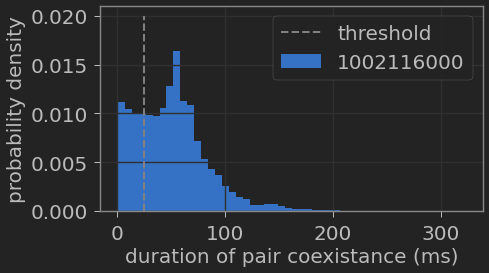

In [17]:
#test that duration is strictly positive
assert ( (df_intersecting_pairs_all['duration']>0).all() )
if printing:
    print (f"verified that the duration is strictly positive for all pairs of tips that coexist nontrivially")

#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
yv=np.linspace(0,0.02,10)
ax.plot(minimum_duration_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
trial_col_lst=sorted(df_intersecting_pairs_all[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_intersecting_pairs_all.query(f"{trial_col} == {trial}")['duration'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial)#,color='event_id_int')
format_plot(ax, xlabel='duration of pair coexistance (ms)', ylabel='probability density', fontsize=fontsize, use_loglog=False)

ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

In [18]:
#DONE: histograms sanity check df_intersecting_pairs
#DONE: verify that routine gives different values for different event_id_int
#DONE: wrap generation of df_intersecting_pairs into a function 
#DONE: include event_id_int outside ^that function
#DONE: accumulate df_intersecting_pairs_all over all event_id_int_values

In [19]:
#DONE: verify that no pair points to the same spiral tip twice
assert ( not (df_intersecting_pairs_all['pid_self']==df_intersecting_pairs_all['pid_other']).any() )

In [20]:
#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
else:
    df_pairs=df_intersecting_pairs_all
#and sort
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()

In [68]:
df_pairs['pid_self'].size

8781

In [23]:
# targ_index_col_lst=[trial_col,'pid_self','pid_other',t_col]
targ_index_col_lst=[trial_col,pid_col,t_col]
df[targ_index_col_lst]
# df_pairs[targ_index_col_lst]

,event_id_int,particle,t
0,1002116000,6,123.0
1,1002116000,6,123.5
2,1002116000,6,124.0
3,1002116000,6,124.5
4,1002116000,6,125.0
...,...,...,...
369079,1002116000,17746,29997.5
369080,1002116000,17746,29998.0
369081,1002116000,17746,29998.5
369082,1002116000,17746,29999.0


In [26]:
dfmi=df.set_index(targ_index_col_lst)
type(dfmi)

cudf.core.dataframe.DataFrame

In [103]:
dfmi.index[0]
dmis

,pid_self,pid_other,tmin_self,tmin_other,tmax_self,tmax_other,tmin,tmax,duration,event_id_int
particle,,,,,,,,,,
20,20,49,168.0,206.5,246.5,311.0,206.5,246.5,40.0,1002116000
20,20,47,168.0,190.0,246.5,260.5,190.0,246.5,56.5,1002116000
20,20,46,168.0,190.0,246.5,367.0,190.0,246.5,56.5,1002116000
20,20,53,168.0,207.0,246.5,345.5,207.0,246.5,39.5,1002116000
20,20,25,168.0,172.0,246.5,373.5,172.0,246.5,74.5,1002116000
...,...,...,...,...,...,...,...,...,...,...
17701,17701,17690,29904.0,29880.5,29999.5,29936.5,29904.0,29936.5,32.5,1002116000
17701,17701,17673,29904.0,29840.5,29999.5,29944.5,29904.0,29944.5,40.5,1002116000
17701,17701,17715,29904.0,29912.5,29999.5,29999.5,29912.5,29999.5,87.0,1002116000


In [117]:
#SUPPOSING THERE IS ONLY ONE EVENT_ID_INT PRESENT
# list(zip(targ_index_col_lst,targ_index_col_lst
# dmis=df_pairs.set_index([trial_col,pid_col])
# dmit=df.set_index([trial_col,pid_col])

df_pairs[pid_col]=df_pairs['pid_self']
dmis=df_pairs.set_index(pid_col)
dmit=df.set_index(pid_col)
df_traj=dmit.loc[dmis.index.values].copy().reset_index()
df_traj.rename(columns={pid_col:'pid_self'},inplace=True)


df_pairs[pid_col]=df_pairs['pid_other']
dmis=df_pairs.set_index(pid_col)
dmit=df.set_index(pid_col)
df_traj_other=dmit.loc[dmis.index.values].copy().reset_index()
df_traj_other.rename(columns={pid_col:'pid_other','x':'x_other','y':'y_other'},inplace=True)
df_traj_other.head()

df_traj['pid_other']=df_traj_other['pid_other']
df_traj['x_other']=df_traj_other['x_other']
df_traj['y_other']=df_traj_other['y_other']
df_traj.head()

,pid_self,index,x,y,t,event_id_int,dx_unwrap,dy_unwrap,pid_other,x_other,y_other
0,20,1368,35.771590,196.579421,218.5,1002116000,0.0,0.0,49,182.144932,129.010885
1,20,1377,35.836662,196.529905,219.0,1002116000,0.0,0.0,49,182.121084,129.095157
2,20,1380,35.891611,196.431926,219.5,1002116000,0.0,0.0,49,182.385496,128.779511
3,20,1398,35.747419,197.018997,220.0,1002116000,0.0,0.0,49,182.632531,128.542276
4,20,1408,35.307198,197.480187,220.5,1002116000,0.0,0.0,49,182.701512,128.515123


In [118]:
df_traj

,pid_self,index,x,y,t,event_id_int,dx_unwrap,dy_unwrap,pid_other,x_other,y_other
0,20,1368,35.771590,196.579421,218.5,1002116000,0.0,0.0,49,182.1449325,129.0108855
1,20,1377,35.836662,196.529905,219.0,1002116000,0.0,0.0,49,182.1210837,129.095157
2,20,1380,35.891611,196.431926,219.5,1002116000,0.0,0.0,49,182.3854958,128.7795106
3,20,1398,35.747419,197.018997,220.0,1002116000,0.0,0.0,49,182.6325306,128.5422762
4,20,1408,35.307198,197.480187,220.5,1002116000,0.0,0.0,49,182.7015125,128.5151227
...,...,...,...,...,...,...,...,...,...,...,...
2074596,17715,561658,16.683256,195.409397,29923.0,1002116000,0.0,0.0,<NA>,<NA>,<NA>
2074597,17715,561666,16.744251,195.431649,29923.5,1002116000,0.0,0.0,<NA>,<NA>,<NA>
2074598,17715,561684,16.533054,195.267053,29924.0,1002116000,0.0,0.0,<NA>,<NA>,<NA>
2074599,17715,561694,16.508326,195.242282,29924.5,1002116000,0.0,0.0,<NA>,<NA>,<NA>


In [124]:
#DONE: compute the three options for the square distance with pbc
d=df_traj
d['sdx']=(d['x']-d['x_other'])**2
d['sdxp']=(d['x']-d['x_other']+width)**2
d['sdxm']=(d['x']-d['x_other']-width)**2
d['sdy']=(d['y']-d['y_other'])**2
d['sdyp']=(d['y']-d['y_other']+height)**2
d['sdym']=(d['y']-d['y_other']-height)**2
d['minsdx']=d[['sdx','sdxp','sdxm']].min(axis=1)
d['minsdy']=d[['sdy','sdyp','sdym']].min(axis=1)
d['dist']=(d['minsdx'] + d['minsdy'])**0.5
d['R']=d['dist']
df_traj.head()

,pid_self,index,x,y,t,event_id_int,dx_unwrap,dy_unwrap,pid_other,x_other,...,sdx,sdxp,sdxm,sdy,sdyp,sdym,minsdy,minsdx,dist,R
0,20,1368,35.771590,196.579421,218.5,1002116000,0.0,0.0,49,182.144932,...,21425.155494,2875.818358,119974.492630,4565.507057,71592.921457,17538.092657,4565.506836,2875.818359,86.263115,86.263115
1,20,1377,35.836662,196.529905,219.0,1002116000,0.0,0.0,49,182.121084,...,21399.131900,2885.363400,119912.900400,4547.445224,71521.344384,17573.546064,4547.445312,2885.363281,86.213737,86.213737
2,20,1380,35.891611,196.431926,219.5,1002116000,0.0,0.0,49,182.385496,...,21460.458202,2862.904394,120058.012010,4576.849337,71637.815577,17515.883097,4576.849121,2862.904297,86.254005,86.254005
3,20,1398,35.747419,197.018997,220.0,1002116000,0.0,0.0,49,182.632531,...,21575.236060,2821.191352,120329.280768,4689.061346,72079.749826,17298.372866,4689.061523,2821.191406,86.661713,86.661713
4,20,1408,35.307198,197.480187,220.5,1002116000,0.0,0.0,49,182.701512,...,21725.084006,2767.358126,120682.809886,4756.180108,72342.205868,17170.154348,4756.180176,2767.358154,86.738335,86.738335


In [127]:
#isolate only the desired columns
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()

In [137]:
#TODO: compute 1/R and dRdt_naive
#take the navg2=2 moving average to get the naive midpoint
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
df_Rt_avg=grouped.rolling(2).mean()
# df_R.set_index([trial_col,'pid_self','pid_other'])['R'].diff().isna().sum()

In [ ]:
def diff_cu(incol,outcol):
    pass
#TODO(heretim):compute the difference between two successive R values for each group
#HINT: find that previous implementation where user defined functions were used in cudf
#HINT: google cudf user defined functions

In [139]:
# grouped.shift(1)[t_col]-grouped[t_col]
grouped.apply_grouped(diff_cu,incol='t',outcol='dt')

TypeError: unsupported operand type(s) for -: 'Series' and 'SeriesGroupBy'

In [67]:
# # dmis.to_pandas().index
# dmis.to_pandas().index.values.T
# dmis.to_pandas().index.values.T.shape

(8781,)

In [79]:
# targ_index=dmis.to_pandas().index.values
# # .set_dtype(int)

In [71]:
dmis.to_pandas().index.values.T.shape,dfmi.to_pandas().shape

((8781,), (369084, 5))

In [83]:

dfmi.to_pandas().loc[tuple(targ_index)]
# dfmi.to_pandas().iloc[[0,0],'x']

SyntaxError: invalid syntax (1632096665.py, line 1)

In [ ]:

# grouped.get_group

In [ ]:
#doesn't work for cudf yet...
# import functools
# S = pd.Series([i / 100.0 for i in range(1, 11)])
# def cum_ret(x, y):
#     return x * (1 + y)
# def red(x):
#     return functools.reduce(cum_ret, x, 1.0)
# S.expanding().apply(red, raw=True)

In [ ]:
# df_pairs[trial_col].drop_duplicates().values.get()
# MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES
# multiplicity_self(level=1)
mi=multiplicity_self.index
pid_self_values=mi.get_level_values(1).values
multiplicity_self_values=multiplicity_self.values
# pid_self_values.shape,multiplicity_self_values.shape
target_pid_index_values=cp.repeat(pid_self_values,tuple(multiplicity_self_values.get()))
print(target_pid_index_values.shape)
#TODO: for each member of pid_self_values, copy it multiplicity_self_values times
#WARNING: watch out for multiple event_id_int values!
#SOLN: use loc on df indexed with TRIAL_COL then PID_COL as dfp

In [ ]:
# retval=cp.repeat(pid_self_values,multiplicity_self_values.get(),axis=-1)
# cp.broadcast_to?
trial_self_values=mi.get_level_values(0).values
multiplicity_self_values=multiplicity_self.values
target_trial_values=cp.repeat(trial_self_values,tuple(multiplicity_self_values.get()))
print(target_trial_values.shape)

In [ ]:
dfr=cudf.DataFrame({trial_col:target_trial_values,pid_col:target_pid_index_values})
dfr.head()

In [ ]:
dmi=df_pairs.groupby([trial_col,'pid_self','pid_other'])
dmi.count()

In [ ]:
# type(dmi.collect())

In [ ]:
df.groupby([pid_col])

In [ ]:
dfc=df.groupby([trial_col,pid_col]).collect()
dfc.head()

In [ ]:
retval=df.set_index([trial_col,pid_col])#.loc[trial_self_values]#,pid_self_values]]
retval=df.set_index([trial_col,pid_col])[[list(trial_self_values.get()),list(pid_self_values.get())]]
retval

In [ ]:
all_t_values=df[t_col].drop_duplicates().values

In [ ]:
#TODO: make the largest possible multiindexed array that contains the target
cudf.DataFrame([target_trial_values,target_pid_index_values])

In [ ]:
cudf.MultiIndex.f

In [ ]:
multiplicity_self_values.get()

In [ ]:
df.loc[]

In [ ]:
#THIS IS THE SHORTEST PATH TO Success
df.loc[[0,0]]
#can I repeat a label? using loc. yes!  THIS CAN BE SOLVE SIMPLY BY 
# USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_self OF EACH PID_SELF
multiplicity_self=df_pairs.groupby([trial_col,'pid_self'])['tmin'].count()
# # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_other OF EACH PID_OTHER
# SET THE INDEX TO PID_COL IN DF AS DFP
dfp=df.set_index(pid_col)
# MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES

# LOCATE AND COPY DF WITH ^THAT LIST FOR SELF
# MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES
# LOCATE AND COPY DF WITH ^THAT LIST FOR OTHER
# MAKE A SINGLE DF WITH ALL OF THE DESIRED COLUMNS (SEE HANDWRITTEN (3))
# REWRITE A PANDASESQUE DIST_L2_PBC_CUDF MEASURE 
# COMPUTE THE CUDF DATAFRAME OF ALL RANGE TIMESERIES FOR ALL PAIRS
# MULTIINDEX SO THE PRIMITIVE OBJECT IS THE RANGE TIME SERIES
# COMPUTE KEY VALUES 1/R AND DRDT
# NAIVELY MEASURE A
# REMOVE OUTLIER A VALUES OR A THAT RECIEVED A NASTY FIT
# RECOMPUTE A WITH AN ENSEMBLE BOOTSTRAP
# IF A IS STILL NOT GREAT, CONSIDER USINVE TAVG2 WITH SOMETHING LIKE A SAVGOL FILTER IMPLEMENTED AS AN FIR FILTER
# KEEP TRYING UNTIL I HAVE AN ESTIMATE OF A THAT IS CONSISTENT WITH THE PARTICLE MODEL

In [ ]:
# targ_index_col_lst=[trial_col,'pid_self','pid_other',t_col]
# df_pairs[targ_index_col_lst]



In [ ]:
df.head()

In [ ]:
# event_id_int=int(event_id_int_values[0].get())
# print(event_id_int)
# pid_self_values=df_pairs.loc[df_pairs[trial_col]==event_id_int,'pid_self'].values#.get()
# #I can't simply query df with pid_self_values because I need multiple copies of the trajectories for each member of df_pair
# #TODO: compute a dataframe with pid,x,y,t for any pid occuring in df_pairs['pid_self']
# # df_traj=df.query(f"{pid_col} in {}")

In [ ]:
# df.pivot(columns='var', values='val')

In [ ]:
# shape=(width,height)
# testing=True
# event_id_int_values=df[trial_col].drop_duplicates().values
# event_id_int=event_id_int_values.get()[0]
# index_lst=[]
# dist_values_lst=[]
# for event_id_int in event_id_int_values.get():
#     for index,pair in df_pairs.to_pandas().iterrows(): #TODO: parallelize with db
#         #         index_test=int(pair.name)
#         #         assert(index==index_test)
#         dff=df[df[trial_col]==event_id_int]
#         self_values,other_values=extract_xy_values_of_pair(dff,pair,t_col)
#         dist_values=distance_L2_pbc_cu(self_values,other_values,shape)
#         #record
#         index_lst.append(index)
#         dist_values_lst.append(dist_values)
#         if testing:
#             #print((self_values.shape,other_values.shape))
#             assert ( self_values.shape==other_values.shape ) 
#         self_values.shape

In [ ]:
dist_values=distance_L2_pbc_cu(self_values,other_values,shape)

In [ ]:
self_values.shape,other_values.shape,shape

In [ ]:
# # self_values-
# # other_values
# # self_values#.get().shape

# #PROBLEM IDENTIFIED: other_values is empty for some reason...
# self_values,other_values=extract_xy_values_of_pair(dff,pair,t_col)
# other_values

In [ ]:
# #DONE: visually verify these values look sensible
# plt.plot(dist_values.get())
# plt.show()
# plt.plot(self_values[:,0].get(),self_values[:,1].get())
# plt.plot(other_values[:,0].get(),other_values[:,1].get())
# plt.show()

In [ ]:
#is there a datum missing somewhere in the bulk?  No. removing the first self resolved the problem
#maybe I'm picking up an extra value from the other event_id?
# dff

In [ ]:
# def comp_xy_distance_pbc_cu(self_values,other_values,width,height):
#     pass
# #TODO:compute the distance in x between any points where two spiral tips occur at the same time in t
# #is the best way to do this to project to cupy and to run all rows in  together in a daskbag?  sure.


In [ ]:
# self_values,other_values

In [ ]:
#TODO(IMMEDIATE FOLLOWUP GOAL): show how insensitive a is to choice in navg1 (and/or navg2 if I'm using it!)
#GOAL_QUESTION: does there exist a tavg1 that produces the right expected a for a single termination event??

In [ ]:
#TODO: estimate an ensemble averaged a estimate
#TODO: augment df_interacting_pairs with estimates for a for individual pairs of particles
#TODO: use ^that to filter based on Rsq or Delta_a and recompute an ensemble averaged a estimate

In [ ]:
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()

In [ ]:
# def extract_xy_values_of_pair(df,pair,t_col='t'):
'''
df is a cudf.DataFrame instance of xy trajectories from no more than 1 trial 
pair is a row from a pandas.core.series.Series instance with columns,['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self', 'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int']

Example Usage:
pair=pd.Series(df_pairs.head(1).to_pandas())
event_id_int=int(pair[trial_col])#.values.get())
dff=df[df[trial_col]==event_id_int]
self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
'''
# dff=df
#DONE: optimize data retrieval from pair by using only one gpu-to-cpu memory transfer
pid_self =int(pair['pid_self'])#.values.get())
pid_other=int(pair['pid_other'])#.values.get())
tmin     =float(pair['tmin'])#.values.get())
tmax     =float(pair['tmax'])#.values.get())
#failed to broadcase in cudf
#     if event_id_int is not None:
#         dff=df[df[trial_col]==event_id_int]
#     else:
#         dff=df
df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
self_values =df_self.loc [(df_self [t_col]>=tmin)&(df_self[t_col] <=tmax),['x','y']].values
other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
#     return self_values,other_values

In [ ]:
other_values

In [ ]:
pid_other

In [ ]:
# PROBLEM REPRODUCED
print(*pair)

In [ ]:
self_values.shape,other_values.shape

In [ ]:
df_self.to_pandas().diff().dropna()['t'].describe()

In [ ]:
df_other.to_pandas().diff().dropna()['t'].describe()

In [ ]:
print(*pair.keys())
print(*pair)

In [ ]:
pid_self =int(pair['pid_self'])#.values.get())
pid_other=int(pair['pid_other'])#.values.get())
tmin     =float(pair['tmin'])#.values.get())
tmax     =float(pair['tmax'])#.values.get())
df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
self_values=df_self.loc[(df_self[t_col]>=tmin)&(df_self[t_col]<=tmax),['x','y']].values
other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
other_values

TODO(later): try to figure out how to make everything faster by smooshing together df.pivot with boolean indexing

HINT?: https://pbpython.com/pandas-pivot-table-explained.html

In [ ]:
# pid_other=7589
# df.loc[(df[pid_col]==pid_other)]
# #CONCLUSION, pid 7589 got deleted somewhere...  perhaps this is because I've been overloading dff in locals() with globals() 